In [1]:
import numpy as np
import pandas as pd

from scipy.stats import pearsonr

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline


colors = ['navy', 'turquoise', 'brown', 'red', 'black','green', 'orange', 'pink']
"""
    Summary:
        _
    Args:
        _ (type): _

    Returns:
       _ (type): _
"""

'\n    Summary:\n        _\n    Args:\n        _ (type): _\n\n    Returns:\n       _ (type): _\n'

## 1. Data
The data for this project comes from https://www.imdb.com/interfaces/ as extremely large .tsv (tab-seperated) files, the biggest being over 2GB. In order to conduct train the KMeans++ model I will need to combine all of this data. But first, in order to load it without overloading my system I need to apply some data wranging and engineering. The need for each of these files is briefly explained below.

- akas: I need region data so I can narrow the data to 'US' based films.
- basics: contains movie specific info
- name: contains names of cast and crew along with their reference code (nconst)
- principals: contains order of precedence if more than one nconst (person) is referenced to the same role (i.e. lead vs co-directors)
- ratings: holds IMDB user rating and vote counts

I'm handling this huge memory load by using pandas to read load the data in chunk, and filtering out specific columns and values that are irrelevant to the project. The data is then saved to a .csv file to ensure stability (of my machine) that I load back in.

As of right now, there's a bit of SQL at the bottom of this file that I'm tinkering with.
Also, the data dictionary on imdb.com is incorrect. I'll provide one once the data has been trimmed down and consolidated.

### 1.1 Load & Inspect Each Table
'usecols' is a useful parameter for speeding up the reading in of large files because I can specify just the columns I need pandas to parse.

In .read_csv iterator and chunksize let me specify how much data from each .tsv file will be preprocessed before being recomiled into a dataframe.

In [ ]:
def chunks(path,cols):
    """
    Summary: loads .tsv files in chunks, selecting specific features and filtering unnecessary values.
        _
    Args:
        path (string): local address
        cols (list): features to keep
    Returns:
       df_result (pd.DataFrame): preprocessed dataframe
    """
    PATH = path
    my_chunk = 100000
    # sets up the size and parameters of the file reader
    iter_csv = pd.read_csv(
        PATH,
        na_values=['\\N','nan'],
        delimiter='\t',
        iterator=True,
        dtype='object',
        chunksize=my_chunk,
        usecols=cols)
    
    # the following logic follows that when the function is called, if the string arguement passed through as the path parameter matches the case string, a speciic data engineering process is executed for that specific data.
    if 'rating' in PATH:
        df_result = pd.concat([chunk for chunk in iter_csv])
    elif 'name' in PATH:
        df_result = pd.concat([chunk for chunk in iter_csv])
    elif 'principals' in PATH:
        # there's a number of roles that barely appear in the data.
        #TODO roll these into an 'other'
        principal_roles = ['actor', 'actress','director','writer','producer','composer']
        df_result = pd.concat(
            [chunk[(chunk['ordering'].astype('int') <= 1) & (chunk['category'].isin(principal_roles))]
            for chunk in iter_csv])
        
    elif 'akas' in PATH:
        df_result = pd.concat([chunk[chunk.region == 'US'] for chunk in iter_csv])
        df_result.rename({'titleId': 'tconst'}, axis=1, inplace=True)
    elif 'basics' in PATH:
        # Many films have a list of genres which explodes in dimensionality when one hot encoding. So instead, I'm sticking with the films that're 'quisessentially' a specific genre.
        principle_genres = ['Drama','Comedy','Adventure','Action', 'Horror', 'Thriller', 'Fantasy', 'Crime', 'Family', 'Sci-Fi', 'Mystery',
            'Romance']
        # I also observed a high skew to startYear values so I'm also limiting the scope of the data to just the past 2+ decades.
        df_result = pd.concat([chunk[
            (chunk.titleType == 'movie')
            & (chunk.startYear.between('2000', '2022'))
            & (chunk['genres'].isin(principle_genres))] for chunk in iter_csv])
        
        df_result.startYear = pd.to_numeric(df_result.startYear)
        df_result.runtimeMinutes = pd.to_numeric(df_result.runtimeMinutes)
        df_result = df_result[df_result.runtimeMinutes >= 70]
        df_result.runtimeMinutes = pd.to_numeric(df_result.runtimeMinutes)
        df_result = df_result.drop('titleType', axis=1)
        
    df_result.columns = map(str.lower, df_result.columns)

    return pd.DataFrame(df_result)

In [ ]:

# Each .tsv file is loaded by calling the chunks function using a list of its columns and the local address

col_list = ['tconst','titleType','primaryTitle','startYear','genres','runtimeMinutes']
basics_tsv = '../Data/tsv/basics.tsv'
basics = pd.DataFrame(chunks(basics_tsv,col_list))


col_list = ['titleId','region']
akas_tsv = '../Data/tsv/akas.tsv'
akas = pd.DataFrame(chunks(akas_tsv,col_list))


col_list = ['tconst','ordering','nconst','category'	]
principals_tsv = '../Data/tsv/principals.tsv'
principals = pd.DataFrame(chunks(principals_tsv,col_list))


col_list = ['tconst','averageRating','numVotes']
ratings_tsv = '../Data/tsv/ratings.tsv'
ratings = pd.DataFrame(chunks(ratings_tsv,col_list))


col_list = ['nconst', 'primaryName']
names_tsv = '../Data/tsv/name.tsv'
names = pd.DataFrame(chunks(names_tsv,col_list))


### 1.2 Merging Tables
First, the basics table is filtered by a list of tconst (film specific) values for films that were identified in the akas table as being from the 'US'.
Then the tconst and nconst (person specific) keys are used to merge each table.


In [ ]:

# filtering basics down to only movies from the 'US' region. This'll greatly reduced everything being add from the other tables.
tconst = list(set(akas.tconst.values))
basics = basics[basics['tconst'].isin(tconst)]

data = basics.merge(principals, how='left',on='tconst')
data = data.merge(ratings, how='left',on='tconst')
data = data.merge(names, how='left',on='nconst')

data.drop(['nconst'],axis=1,inplace=True)
data.dropna(inplace=True)
data.to_csv('../Data/data.csv', index=False)
print(len(data))
print(data.info(memory_usage='deep'))
data.head()

### 1.3 Table Inspection

In [2]:
# note the change in memory usage.
data = pd.read_csv('../Data/data.csv')
print(len(data))
data.info(memory_usage='deep')
data.head()

23124
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23124 entries, 0 to 23123
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tconst          23124 non-null  object 
 1   primarytitle    23124 non-null  object 
 2   startyear       23124 non-null  int64  
 3   runtimeminutes  23124 non-null  float64
 4   genres          23124 non-null  object 
 5   ordering        23124 non-null  int64  
 6   category        23124 non-null  object 
 7   averagerating   23124 non-null  float64
 8   numvotes        23124 non-null  int64  
 9   primaryname     23124 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 8.3 MB


,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname
0,tt0062336,The Tango of the Widower and Its Distorting Mi...,2020,70.0,Drama,1,actor,6.4,161,Rubén Sotoconil
1,tt0069049,The Other Side of the Wind,2018,122.0,Drama,1,actor,6.7,7160,John Huston
2,tt0094859,Chief Zabu,2016,74.0,Comedy,1,actor,7.9,82,Allen Garfield
3,tt0096056,Crime and Punishment,2002,126.0,Drama,1,actor,5.7,810,Crispin Glover
4,tt0114447,The Silent Force,2001,90.0,Action,1,actor,4.2,152,Loren Avedon


In [3]:
'''data dictionary
tconst  =   title id of the movie
primarytitle    =   primary title the movie goes by
startyear   =   year realease
runtimeminutes  =   film duration
genres  =   list of each genre the film represents
ordering    =   order of precedence if co-directors/writers/producers
nconst  =   name id or director, writer
category    =   job category7
primaryname =   director/writer name gone by
primaryprofession   =   primary postion of principal
knownfortitles  =   previous works by principle
averagerating   =   films average rating
numvotes    =   number of votes film has received
directors   =   list of directors
writers =   list of writers'''

'data dictionary\ntconst  =   title id of the movie\nprimarytitle    =   primary title the movie goes by\nstartyear   =   year realease\nruntimeminutes  =   film duration\ngenres  =   list of each genre the film represents\nordering    =   order of precedence if co-directors/writers/producers\nnconst  =   name id or director, writer\ncategory    =   job category7\nprimaryname =   director/writer name gone by\nprimaryprofession   =   primary postion of principal\nknownfortitles  =   previous works by principle\naveragerating   =   films average rating\nnumvotes    =   number of votes film has received\ndirectors   =   list of directors\nwriters =   list of writers'

In [4]:
# check for duplcates.
print(f'Number of dupes: {sum(data.duplicated())}')
data[data.duplicated() == True]

#data.drop_duplicates(inplace=True)
#data[data.duplicated() == True]


Number of dupes: 0


,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname


In [5]:
# check for null values
data[data.isnull().any(axis=1)]

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname


In [6]:
# just doublechecking.
data.isna().sum()

tconst            0
primarytitle      0
startyear         0
runtimeminutes    0
genres            0
ordering          0
category          0
averagerating     0
numvotes          0
primaryname       0
dtype: int64

## 2. Initial EDA: Feature Selection
### 2.1 Data Diagnosis

In [7]:
data.describe(include='all')

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname
count,23124,23124,23124.000000,23124.000000,23124,23124.0,23124,23124.000000,23124.000000,23124
unique,23124,22072,NaN,NaN,12,NaN,5,NaN,NaN,19128
top,tt1641410,Home,NaN,NaN,Drama,NaN,actor,NaN,NaN,Eric Roberts
freq,1,7,NaN,NaN,11711,NaN,14094,NaN,NaN,29
mean,NaN,NaN,2013.145866,96.218128,NaN,1.0,NaN,5.858783,1865.275428,NaN
std,NaN,NaN,5.728444,19.952159,NaN,0.0,NaN,1.424790,17739.390320,NaN
min,NaN,NaN,2000.000000,70.000000,NaN,1.0,NaN,1.000000,5.000000,NaN
25%,NaN,NaN,2009.000000,85.000000,NaN,1.0,NaN,5.000000,32.000000,NaN
50%,NaN,NaN,2014.000000,93.000000,NaN,1.0,NaN,6.000000,114.000000,NaN
75%,NaN,NaN,2018.000000,103.000000,NaN,1.0,NaN,6.800000,420.000000,NaN


### 2.2 Categorical Features
I have to pay special attention here. Note that 'primarytitle' and 'primaryname' would dramatically insrease the dimensionality of the data.

In [8]:
data.select_dtypes('object').nunique()

tconst          23124
primarytitle    22072
genres             12
category            5
primaryname     19128
dtype: int64

In [9]:
data.select_dtypes('object')

,tconst,primarytitle,genres,category,primaryname
0,tt0062336,The Tango of the Widower and Its Distorting Mi...,Drama,actor,Rubén Sotoconil
1,tt0069049,The Other Side of the Wind,Drama,actor,John Huston
2,tt0094859,Chief Zabu,Comedy,actor,Allen Garfield
3,tt0096056,Crime and Punishment,Drama,actor,Crispin Glover
4,tt0114447,The Silent Force,Action,actor,Loren Avedon
...,...,...,...,...,...
23119,tt9904552,All for the Money,Comedy,actor,Eugene Bush
23120,tt9904648,The Contrast,Comedy,actor,Lance E. Nichols
23121,tt9904820,American Terror Story,Horror,actress,Rim Basma
23122,tt9913660,No Apology,Drama,actress,Lydia Adair


##### 2.2.a - primarytitle

In [10]:
data.primarytitle.value_counts()

Home                      7
Blackbird                 6
Ritual                    5
Brothers                  5
Hunting Season            5
                         ..
Order of Rights           1
Doubt                     1
My Best Day               1
Sweet Whip                1
Undocumented Executive    1
Name: primarytitle, Length: 22072, dtype: int64

##### 2.2.b - genres

In [11]:
data.genres.value_counts()


Drama        11711
Comedy        4665
Horror        2734
Thriller      1675
Action         663
Romance        496
Family         331
Sci-Fi         263
Crime          207
Mystery        140
Adventure      132
Fantasy        107
Name: genres, dtype: int64

##### 2.2.c - category

In [12]:
data.category.value_counts()

actor       14094
actress      8943
director       83
writer          2
producer        2
Name: category, dtype: int64

In [13]:
# further reducing the number of possible categorical values.
keeps = ['actor', 'actress', 'director']
data = data[data.category.isin(keeps)]

##### 2.2.d - primaryname
This is a huge source of dimensionality. For now I'm simply going to drop anyone who appears only once. This is hand during the .tsv file conversion process further up but I may fine tune here in the the future.

In [14]:
#data = data[data.groupby("primaryname")['primaryname'].transform('size') > 5]
print(data.primaryname.value_counts())
data = data[data.groupby("primaryname")['primaryname'].transform('size') > 1]
data

Eric Roberts            29
Michael Madsen          16
Isabelle Huppert        15
Kevin Sorbo             12
John Schneider          12
                        ..
Ezel Akay                1
Mark Stewart Iverson     1
Jeris Adomanis           1
Taylor Gerard Hart       1
Dominick Brascia         1
Name: primaryname, Length: 19124, dtype: int64


,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname
3,tt0096056,Crime and Punishment,2002,126.0,Drama,1,actor,5.7,810,Crispin Glover
9,tt0118852,Chinese Coffee,2000,99.0,Drama,1,actor,7.1,4254,Al Pacino
10,tt0119231,The Junior Defenders,2007,83.0,Comedy,1,actress,4.6,184,Ally Sheedy
14,tt0120824,The Shipping News,2001,111.0,Drama,1,actor,6.7,32853,Kevin Spacey
15,tt0123581,Burning Down the House,2001,84.0,Comedy,1,actor,4.9,71,John Savage
...,...,...,...,...,...,...,...,...,...,...
23104,tt9892094,Mogul Mowgli,2020,89.0,Drama,1,actor,6.6,2449,Riz Ahmed
23105,tt9893084,Italian Studies,2021,81.0,Drama,1,actress,4.8,424,Vanessa Kirby
23110,tt9898086,Carol of the Bells,2019,100.0,Drama,1,actor,7.2,90,RJ Mitte
23115,tt9900688,Big Three Dragons,2019,111.0,Comedy,1,actress,4.5,29,Ella Chen


In [15]:
print(data.primaryname.value_counts())

Eric Roberts        29
Michael Madsen      16
Isabelle Huppert    15
Kevin Sorbo         12
John Schneider      12
                    ..
Adam LeClair         2
Adil Abdolrahman     2
Adriana Barraza      2
Agnes Bruckner       2
Ryôhei Abe           2
Name: primaryname, Length: 2591, dtype: int64


In [16]:
data.select_dtypes('object')

,tconst,primarytitle,genres,category,primaryname
3,tt0096056,Crime and Punishment,Drama,actor,Crispin Glover
9,tt0118852,Chinese Coffee,Drama,actor,Al Pacino
10,tt0119231,The Junior Defenders,Comedy,actress,Ally Sheedy
14,tt0120824,The Shipping News,Drama,actor,Kevin Spacey
15,tt0123581,Burning Down the House,Comedy,actor,John Savage
...,...,...,...,...,...
23104,tt9892094,Mogul Mowgli,Drama,actor,Riz Ahmed
23105,tt9893084,Italian Studies,Drama,actress,Vanessa Kirby
23110,tt9898086,Carol of the Bells,Drama,actor,RJ Mitte
23115,tt9900688,Big Three Dragons,Comedy,actress,Ella Chen


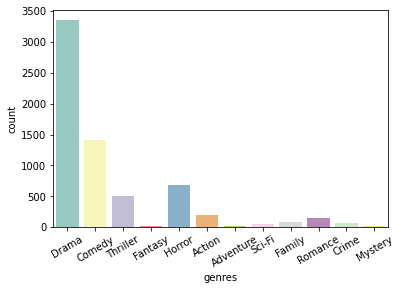

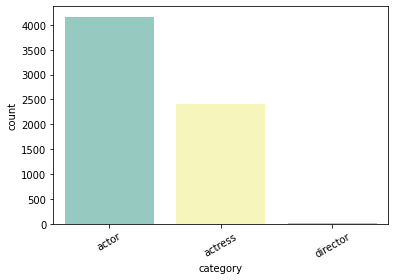

In [17]:
# so much drama...
for f in data[['genres','category']]:
    sns.countplot(x = f, data = data, palette = 'Set3') # hue = '')
    plt.xticks(rotation=30)
    plt.show()

### 2.3 Numeric Features

In [18]:
old = data.describe()
data.select_dtypes('number').nunique()

startyear           23
runtimeminutes     125
ordering             1
averagerating       83
numvotes          2060
dtype: int64

In [19]:
data.select_dtypes('number')

,startyear,runtimeminutes,ordering,averagerating,numvotes
3,2002,126.0,1,5.7,810
9,2000,99.0,1,7.1,4254
10,2007,83.0,1,4.6,184
14,2001,111.0,1,6.7,32853
15,2001,84.0,1,4.9,71
...,...,...,...,...,...
23104,2020,89.0,1,6.6,2449
23105,2021,81.0,1,4.8,424
23110,2019,100.0,1,7.2,90
23115,2019,111.0,1,4.5,29


##### 2.3.a - startyear
- The average start year for the films in this selection is 2009.
- This distribution should be plotted with lines indicating centers.

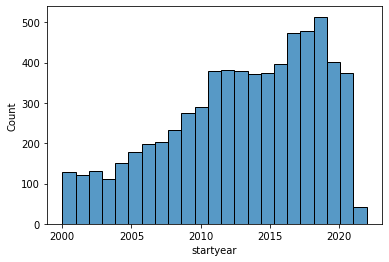

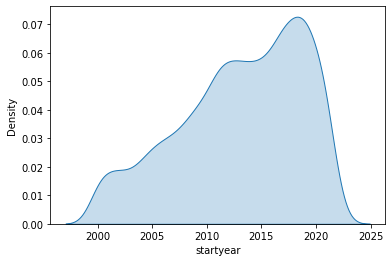

In [20]:
sns.histplot(data.startyear)
plt.show()
sns.kdeplot(data.startyear, shade=True, label='data')
plt.show()

##### 2.3.b - averagerating
- This is likely to be some sort of target in the future, linear regression would be great to take this project a step further.

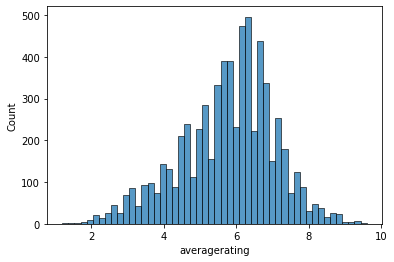

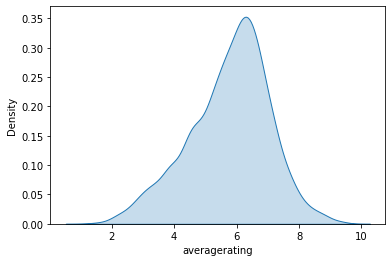

In [21]:
sns.histplot(data.averagerating)
plt.show()
sns.kdeplot(data.averagerating, shade=True, label='data')
plt.show()


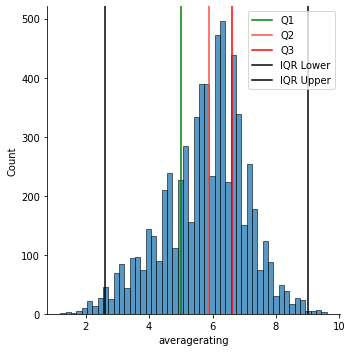

In [22]:
# Using Numpy I'll first calculate the IQR, then use it to identify and remove outliers found in the averagerating feature.
q1 = np.quantile(data.averagerating, 0.25)
q2 = np.quantile(data.averagerating, 0.5)
q3 = np.quantile(data.averagerating, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(data.averagerating)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.legend()
plt.show()
#TODO come back and trim this

In [23]:
# trimming off everything above and below the threshold.
# Intuition on this dictates that we want data that extreme outliers can lead to groupings - ansd their centroids, being dragged out due to these skewed data.
data = data[data.averagerating >= iqr_lower]
data = data[data.averagerating <= iqr_upper]

In [24]:
data.shape
# we've lost only a small number of rows.
#TODO get the original number and show difference.

(6473, 10)

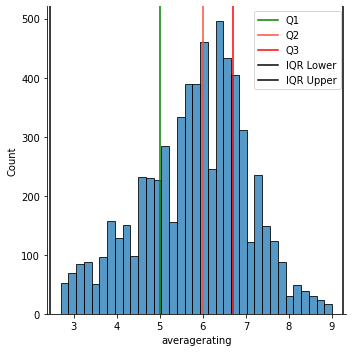

In [25]:

# checking out the new distribution using the new IQR.
q1 = np.quantile(data.averagerating, 0.25)
q2 = np.quantile(data.averagerating, 0.5)
q3 = np.quantile(data.averagerating, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(data.averagerating)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')

plt.legend()
plt.show()



In [26]:
data = data[data.averagerating > iqr_lower]
data = data[data.averagerating < iqr_upper]
data.shape

(6473, 10)

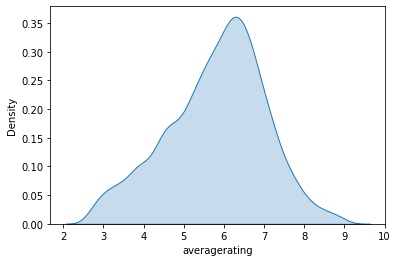

In [27]:
sns.kdeplot(data.averagerating, shade=True, label='data')
plt.show()

In [28]:
# checking out these new summary stats
# the max is a more realistic two hours or so while the mean remains about the same. The standard deviation has also been halved.
data.averagerating.describe(include = 'all')

count    6473.000000
mean        5.804094
std         1.230320
min         2.700000
25%         5.000000
50%         6.000000
75%         6.700000
max         9.000000
Name: averagerating, dtype: float64

### 2.4 Feature Associations

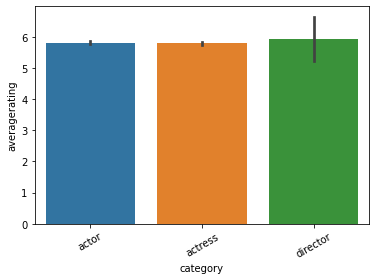

In [29]:
ax = sns.barplot(data=data,x=data.category,y=data.averagerating)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()

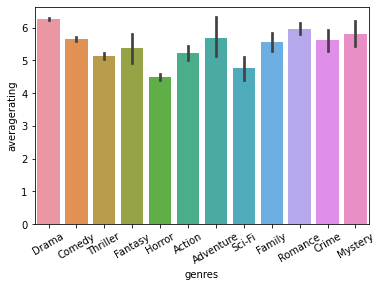

In [30]:
ax = sns.barplot(data=data,x=data.genres,y=data.averagerating)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.show()
#TODO sort this and amke wider for x labels

In [31]:
data.category.value_counts()

actor       4084
actress     2375
director      14
Name: category, dtype: int64

In [32]:
data.primarytitle.value_counts()

Home               4
Sisters            3
High Society       3
Homeland           3
Alice              3
                  ..
Love on a Wkend    1
Die Präsenz        1
Smuggler           1
The Binge          1
Fly Away           1
Name: primarytitle, Length: 6365, dtype: int64

## 3. Feature Selection & Hyperparameter Tuning
After checking a range of cluster quantities I'm going to use principal component analysis from Sklearn to to reduce the dimensionality of the data. In fact, one hot encoding is used in the next cell 



#### 3.1 Feature Selection

A key concept with PCA is that the first features considered matter the most - I'd originally struggled to get good metrics because of how I was feeding data in via the pipeline.
primaryname explodes when one hot encoded, primarytitle follows. Since i'd reduced genres down to a list of quintessential genres (i.e. not a list of genres. "Drama" vs "['Drama', 'Horror']").
In the cell below I'm setting up to run summary analysis on numeric features. Noting the difference in quantirty between the appearance of unique values, I'm arranging the pipelie  of their unique value

In [35]:
ohe = ['category','genres','tconst','primaryname']
for i in ohe:
    print(f'{i} {data[i].nunique()}')

from sklearn.preprocessing import OrdinalEncoder

category 3
genres 12
tconst 6473
primaryname 2588


In [40]:
X = data
ordi = OrdinalEncoder()
X['title'] = ordi.fit_transform(pd.DataFrame(X.primarytitle))
X['name'] = ordi.fit_transform(pd.DataFrame(X.primaryname))
X['const'] = ordi.fit_transform(pd.DataFrame(X.tconst))
ohe = ['category','genres']
scal_cols = ['startyear','averagerating','numvotes','runtimeminutes','title','name','const']


### 3.2 Feature Encoding
I'm using a column transformer to encode the data, x_train, that I can use for both finding the optimal k and also conducting PCA.

In [85]:
from sklearn.preprocessing import OrdinalEncoder


preprocessor = ColumnTransformer(
    transformers=[
        #('ordi', OrdinalEncoder(), ordi),
        ('scaler', StandardScaler(), scal_cols),
        ('ohe', OneHotEncoder(handle_unknown ='ignore'), ohe)
        
        ],remainder='drop')


x_train = preprocessor.fit_transform(X)


In [86]:
# just looking to see what the training data looks like. So ohe columns..
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1.946376,-0.084614,-0.107592,1.440747,-1.034493,-1.058667,-1.731783,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.298852,1.053390,0.017052,0.013952,-1.117202,-1.665329,-1.731248,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.065187,-0.978759,-0.130248,-0.831557,1.089288,-1.594351,-1.730713,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.122614,0.728246,1.052093,0.648083,1.281369,0.030110,-1.730178,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-2.122614,-0.734901,-0.134338,-0.778712,-1.181955,-0.216304,-1.729643,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6468,1.225906,0.646960,-0.048274,-0.514491,0.065215,0.942111,1.729643,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6469,1.402144,-0.816187,-0.121562,-0.937245,-0.298271,1.547434,1.730178,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6470,1.049668,1.134676,-0.133650,0.066796,-1.149851,0.840331,1.730713,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6471,1.049668,-1.060045,-0.135858,0.648083,-1.294592,-0.818949,1.731248,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.3 Optimal K: Elbow Method

The inertia for : 1 Clusters is: 52677.60435655781
The inertia for : 2 Clusters is: 44643.46757487224
The inertia for : 3 Clusters is: 40333.43623383216
The inertia for : 4 Clusters is: 36429.10319571969
The inertia for : 5 Clusters is: 34089.71225319142
The inertia for : 6 Clusters is: 32123.321860858417
The inertia for : 7 Clusters is: 30209.597042038302
The inertia for : 8 Clusters is: 29074.784582115284
The inertia for : 9 Clusters is: 28008.392325047622
The inertia for : 10 Clusters is: 27150.20023879509
The inertia for : 11 Clusters is: 26128.00105100268
The inertia for : 12 Clusters is: 25427.722547500045
The inertia for : 13 Clusters is: 24761.613826949582
The inertia for : 14 Clusters is: 23989.973668401915


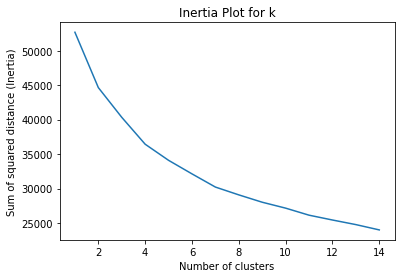

In [87]:
cs = []
c_dict = {}
n_clusters = [range(1, 15)]
for k in range(1, 15):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 30, n_init = 4, random_state = 42)
    kmeans.fit(x_train)
    cs.append(kmeans.inertia_)
    if k not in c_dict.keys():
        c_dict[k] = kmeans.inertia_

    print("The inertia for :", k, "Clusters is:", kmeans.inertia_)
plt.plot(range(1, 15), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance (Inertia)')
plt.title("Inertia Plot for k")
plt.show()


In [88]:
# Using the best k shown by the elbow method to train a new model.
kmeans = KMeans(n_clusters = 7, init = 'k-means++', max_iter = 20, n_init = 8, random_state = 42)
kmeans.fit(x_train)

# saving for PCA
labels = set(kmeans.labels_)
# saving for PCA
y_pred = kmeans.predict(x_train)
# saving this to compare with final model
old_inertia = kmeans.inertia_
# labels for plot legend
target_labels = [f'Cluster {1+x}' for x in labels]
print(f'Model Inertia: {kmeans.inertia_}')
print(f'Model Label: {labels}')

Model Inertia: 30243.625284539292
Model Label: {0, 1, 2, 3, 4, 5, 6}


### 3.3 Principal Component Analysis


In [89]:
n_components = 2
pca = PCA(n_components=n_components, random_state = 42)
X_r = pca.fit_transform(x_train)

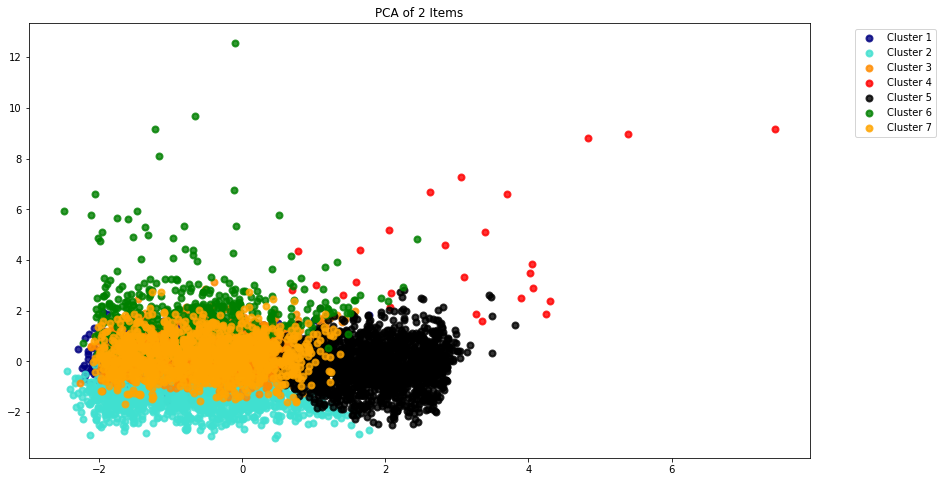

In [90]:



plt.figure(1, figsize=(14, 8))
for color, i, target_name in zip(colors[:len(target_labels)], list(range(len(target_labels))), target_labels):
    plt.scatter(X_r[y_pred == i, 0], X_r[y_pred == i, 1], color=color, alpha=.8, lw=2,label=target_name)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title(f'PCA of {n_components} Items')
plt.show()

In [91]:
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))


Explained variance ratio (first two components): [0.21366436 0.16416341]


In [92]:
x_train.shape[1]

22

#### 3.4.1 Finding Optimal N-Components Using Optimal K
In order to find the optimal number of components to abstract the feature set into I need to analyze the entire table to find both the total variance and its 95% percentile. The number of components that can reduce variance by 5% is what we'll go with.

In [93]:
n_components = x_train.shape[1]
pca = PCA(n_components=n_components, random_state = 42)
X_r = pca.fit_transform(x_train)

Total Variance in our dataset is:  8.139308460531216
The 95% variance we want to have is:  7.732343037504656

Variance explained with 5 compononets:  6.024868035980395
Variance explained with 10 compononets:  7.9419407495405085
Variance explained with 15 compononets:  8.115530055048172
Variance explained with 20 compononets:  8.139308460531216


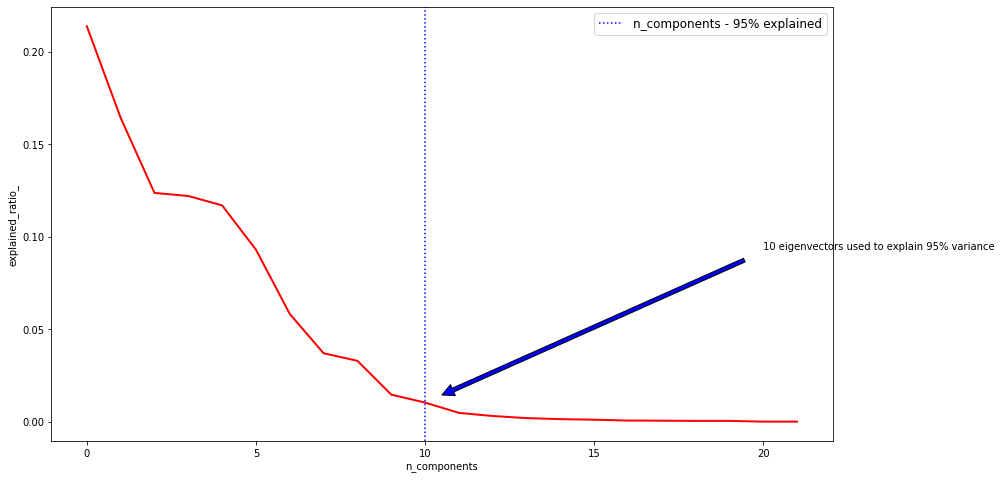

The best is 10 components which yields 7.9419407495405085


In [94]:

total_variance = sum(pca.explained_variance_)
print('Total Variance in our dataset is: ', total_variance)
var_95 = total_variance * 0.95
print('The 95% variance we want to have is: ', var_95)
print('')
# Creating a df with the components and explained variance
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns=['PCA Comp', 'Explained Variance'])

# Trying to hit 95%

d = 1
v = []
best = []

for i in range(len(a)):
    if len(v) > a.shape[0]*.9:
        if sum(v[-5:])/5 == v[:-1]:
            break
    else:
        v.append(sum(a['Explained Variance'][0:d]))
        if d%5 == 0:
            print(f'Variance explained with {d} compononets: ', sum(a['Explained Variance'][0:d]))
            if sum(a['Explained Variance'][0:d]) >= var_95:
                best.append((d,sum(a['Explained Variance'][0:d])))
        d += 1


best_c = best[0][0]
best_v = best[0][1]


# Plotting the Data
plt.figure(1, figsize=(14, 8))
plt.plot(pca.explained_variance_ratio_, linewidth=2, c='r')
plt.xlabel('n_components')
plt.ylabel('explained_ratio_')

# Plotting line with 95% e.v.
plt.axvline(best_c,linestyle=':', label='n_components - 95% explained', c ='blue')
plt.legend(prop=dict(size=12))

# adding arrow
plt.annotate(f'{best_c} eigenvectors used to explain 95% variance', xy=(best_c, pca.explained_variance_ratio_[best_c]), 
             xytext=(best_c+10, pca.explained_variance_ratio_[5]),
            arrowprops=dict(facecolor='blue', shrink=0.05))

plt.show()

print(f'The best is {best_c} components which yields {best_v}')

#### 3.4.2 Rechecking Optimal K Using Optimal N-Components
Using PCA with this optimal number of components to add a preprocessing layer to the data before applying KMeans.

In [95]:
pca = PCA(n_components=best_c)
X_r = pca.fit_transform(x_train)

The inertia for : 1 Clusters is: 51400.24053102614
The inertia for : 2 Clusters is: 43366.1826209774
The inertia for : 3 Clusters is: 39455.01905869727
The inertia for : 4 Clusters is: 35152.49023229194
The inertia for : 5 Clusters is: 33864.13108189321
The inertia for : 6 Clusters is: 30738.40503241582
The inertia for : 7 Clusters is: 28936.65694055236
The inertia for : 8 Clusters is: 27786.77112120177
The inertia for : 9 Clusters is: 26833.418437282675
The inertia for : 10 Clusters is: 25737.477627646433


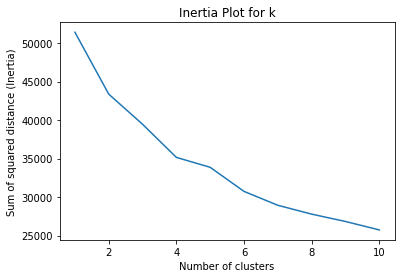

In [96]:
inertia = []
cs = []
n_clusters = [range(1, 11)]
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 20, n_init = 4, random_state = 42)
    kmeans.fit(X_r)
    cs.append(kmeans.inertia_)
    if k not in c_dict.keys():
        c_dict[k] = kmeans.inertia_

    print("The inertia for :", k, "Clusters is:", kmeans.inertia_)
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance (Inertia)')
plt.title("Inertia Plot for k")
plt.show()

In [97]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', max_iter = 20, n_init = 4, random_state = 42)
kmeans.fit(X_r)

KMeans(max_iter=20, n_clusters=7, n_init=4, random_state=42)

In [98]:
y_pred = kmeans.predict(X_r)
y_pred


array([4, 4, 4, ..., 0, 5, 5], dtype=int32)

In [99]:
data['y_pred'] = y_pred
data

,tconst,primarytitle,startyear,runtimeminutes,genres,ordering,category,averagerating,numvotes,primaryname,title,name,const,y_pred,cluster
3,tt0096056,Crime and Punishment,2002,126.0,Drama,1,actor,5.7,810,Crispin Glover,1277.0,501.0,0.0,4,4
9,tt0118852,Chinese Coffee,2000,99.0,Drama,1,actor,7.1,4254,Al Pacino,1125.0,48.0,1.0,4,4
10,tt0119231,The Junior Defenders,2007,83.0,Comedy,1,actress,4.6,184,Ally Sheedy,5180.0,101.0,2.0,4,4
14,tt0120824,The Shipping News,2001,111.0,Drama,1,actor,6.7,32853,Kevin Spacey,5533.0,1314.0,3.0,4,4
15,tt0123581,Burning Down the House,2001,84.0,Comedy,1,actor,4.9,71,John Savage,1006.0,1130.0,4.0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23104,tt9892094,Mogul Mowgli,2020,89.0,Drama,1,actor,6.6,2449,Riz Ahmed,3298.0,1995.0,6468.0,2,2
23105,tt9893084,Italian Studies,2021,81.0,Drama,1,actress,4.8,424,Vanessa Kirby,2630.0,2447.0,6469.0,2,2
23110,tt9898086,Carol of the Bells,2019,100.0,Drama,1,actor,7.2,90,RJ Mitte,1065.0,1919.0,6470.0,0,0
23115,tt9900688,Big Three Dragons,2019,111.0,Comedy,1,actress,4.5,29,Ella Chen,799.0,680.0,6471.0,5,5


In [100]:
print(f'old inertia: {old_inertia}')
print(f'new inertia: {kmeans.inertia_}')
print(f'change:     {old_inertia-kmeans.inertia_}')

old inertia: 30243.625284539292
new inertia: 28936.656940552355
change:     1306.9683439869368


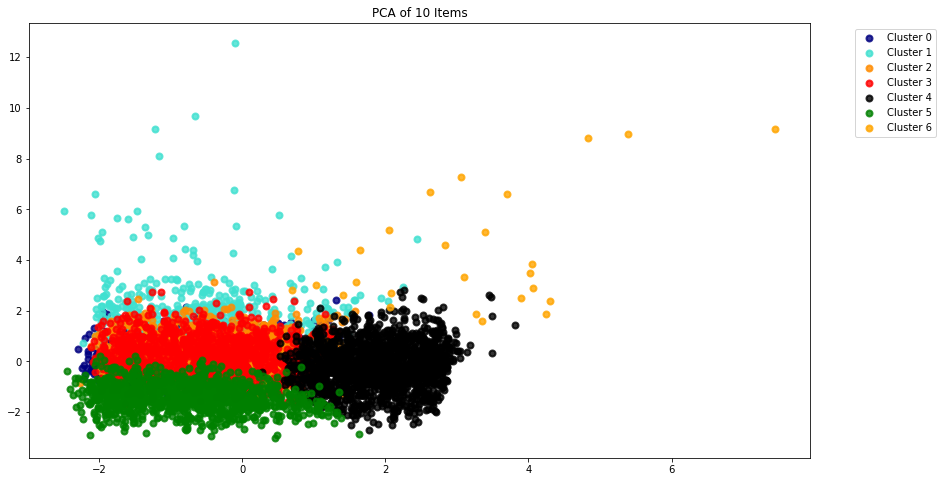

In [101]:
labels = set(kmeans.labels_)
target_labels = [f'Cluster {x}' for x in labels]
target_labels


plt.figure(1, figsize=(14, 8))

colors = ['navy', 'turquoise', 'darkorange', 'red', 'black','green', 'orange','pink']
for color, i, target_name in zip(colors[:len(target_labels)], list(range(len(target_labels))), target_labels):
    plt.scatter(X_r[y_pred == i, 0], X_r[y_pred == i, 1], color=color, alpha=.8, lw=2,label=target_name)



plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title(f'PCA of {best_c} Items')
plt.show()



In [102]:
data['cluster'] = y_pred
cluster_1 = data[data.cluster == 0]
cluster_2 = data[data.cluster == 1]
cluster_3 = data[data.cluster == 2]
cluster_4 = data[data.cluster == 3]
cluster_5 = data[data.cluster == 4]
data.columns

Index(['tconst', 'primarytitle', 'startyear', 'runtimeminutes', 'genres',
       'ordering', 'category', 'averagerating', 'numvotes', 'primaryname',
       'title', 'name', 'const', 'y_pred', 'cluster'],
      dtype='object')

In [103]:
cluster_4.genres.value_counts()

Drama        670
Comedy       232
Thriller      71
Horror        48
Action        24
Romance       23
Family        16
Crime         11
Mystery        6
Fantasy        6
Sci-Fi         5
Adventure      3
Name: genres, dtype: int64

In [ ]:
cluster_5.genres.value_counts()

In [ ]:
data.genres.value_counts()

In [ ]:
ohe = OneHotEncoder()
z = ohe.fit_transform(pd.DataFrame(data.category))
pd.DataFrame(z.toarray())
